In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-vo3uh67e
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-vo3uh67e
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4289 sha256=b4becf70795982bca2c5a24735589b17f7eb64f64055415f92aecf396027b229
  Stored in directory: /tmp/pip-ephem-wheel-cache-zae9utev/wheels/db/c1/1f/a2bb07bbb4a1ce3c43921252aeafaa6205f08637e292496f04
Successfully built NVCCPlugin


In [3]:
%load_ext nvcc_plugin

directory /notebooks/src already exists
Out bin /notebooks/result.out


In [4]:
%%cu
#include <cstdlib>
#include <cassert>
#include <iostream>
#include <algorithm>    // std::max
#include <string> // to_string
#include <chrono>
#include <cmath>

using namespace std;
using namespace std::chrono;

#define NUM_THREADS 1024;

int saved_n = -1;
float *g_vector = NULL, *g_result_vector = NULL, *g_temp_result_vector = NULL;

void init_vector(float *vector, int n) {
    for (int i = 0; i < n; i++) {
        vector[i] = rand() % 100 / 2.0f;
    }
}

#define CHECK_ERROR(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

__device__ void warpReduce(volatile float* shmem_ptr, int t) {
	shmem_ptr[t] += shmem_ptr[t + 32];
	shmem_ptr[t] += shmem_ptr[t + 16];
	shmem_ptr[t] += shmem_ptr[t + 8];
	shmem_ptr[t] += shmem_ptr[t + 4];
	shmem_ptr[t] += shmem_ptr[t + 2];
	shmem_ptr[t] += shmem_ptr[t + 1];
}

__global__ void sum_reduction(float *v, float *v_r) {
	__shared__ float partial_sum[1024];
	int tid = blockIdx.x * blockDim.x + threadIdx.x;
	int i = blockIdx.x * (blockDim.x * 2) + threadIdx.x;

	partial_sum[threadIdx.x] = v[i] + v[i + blockDim.x];
	__syncthreads();

	for (int s = blockDim.x / 2; s > 32; s >>= 1) {
		// Each thread does work unless it is further than the stride
		if (threadIdx.x < s) {
			partial_sum[threadIdx.x] += partial_sum[threadIdx.x + s];
		}
		__syncthreads();
	}

	if (threadIdx.x < 32) {
		warpReduce(partial_sum, threadIdx.x);
	}

	if (threadIdx.x == 0) {
		v_r[blockIdx.x] = partial_sum[0];
	}
}

float gpu_vector_sum(const float *vector, const int n) {
	if (n != saved_n) {
		saved_n = n;

		if (g_vector != NULL || g_result_vector != NULL) {
			CHECK_ERROR(cudaFree(g_vector));
			CHECK_ERROR(cudaFree(g_result_vector));
		}
		// Alloc
		CHECK_ERROR(cudaMalloc(&g_vector, n * sizeof(float)));
		CHECK_ERROR(cudaMalloc(&g_result_vector, n * sizeof(float)));
		g_temp_result_vector = (float*)malloc(n * sizeof(float));
	}
    // Transfer the data to the device
    size_t size_vector = n * sizeof(float);
    CHECK_ERROR(cudaMemcpy(g_vector, vector, size_vector, cudaMemcpyHostToDevice));

	// Kernel params
	int THREADS = NUM_THREADS;
	int BLOCKS = max(n / THREADS / 2, 1); // If n << 1024, number of block can be zero, so assign atleast one block, if array too small

	sum_reduction<<<BLOCKS, THREADS>>>(g_vector, g_result_vector);
	sum_reduction<<<1,      THREADS>>>(g_result_vector, g_result_vector);
	CHECK_ERROR(cudaDeviceSynchronize());
    // Transfer the data to the host
    CHECK_ERROR(cudaMemcpy(g_temp_result_vector, g_result_vector, size_vector, cudaMemcpyDeviceToHost));
    
	return g_temp_result_vector[0];
}

float cpu_vector_sum(const float *vector, const int n) {
	float result = 0.0f;
	for (int i = 0; i < n; i++) {
		result += vector[i];
	}
	return result;
}

int main() {
    int n = 1 << 20;
    float* vector = (float*)malloc(n * sizeof(float));
    init_vector(vector, n);
    
    auto startCPU = high_resolution_clock::now();
    float cpu_result = cpu_vector_sum(vector, n);
    auto stopCPU = high_resolution_clock::now();
    auto durationCPU = duration_cast<microseconds>(stopCPU - startCPU);
    
    auto startGPU = high_resolution_clock::now();
    float gpu_result = gpu_vector_sum(vector, n);
    auto stopGPU = high_resolution_clock::now();
    auto durationGPU = duration_cast<microseconds>(stopGPU - startGPU);
    
    cout << "CPU result - " << cpu_result << endl;
    cout << "GPU result - " << gpu_result << endl;
    cout << "Vector size - " << n << endl;
    cout << "Time taken by CPU function: " << durationCPU.count() << " microseconds" << endl;
    cout << "Time taken by GPU function: " << durationGPU.count() << " microseconds" << endl;
    
    assert(cpu_result == gpu_result);
    free(vector);
    return 0; 
}

CPU result - 2.59517e+07
GPU result - 2.59525e+07
Vector size - 1048576
Time taken by CPU function: 3484 microseconds
Time taken by GPU function: 176250 microseconds
62b9e09c-ee68-47b6-a2f8-f14c5dff9eb3.out: /tmp/tmp52kuz_hg/62b9e09c-ee68-47b6-a2f8-f14c5dff9eb3.cu:126: int main(): Assertion `cpu_result == gpu_result' failed.



In [7]:
%%cu
#include <stdio.h>
#include <cuda_runtime.h>
#include <math.h> 
#include "cuda.h"
#include <iostream>
#include <chrono>
#include <cassert>

using namespace std;
using namespace std::chrono;

const int NUM_ELEMENTS = 1 << 12;
const int THREADS_PER_BLOCK = 128;
const int NUM_OPERATIONS = 1;
const float MAXERROR = 0.001;
float* d_A = NULL;
float* d_C = NULL;

// Device functions
__global__ void vectorAdd(const float* A, float* C) {
	__shared__ float sdata[THREADS_PER_BLOCK];

	unsigned int tid = threadIdx.x;
	unsigned int i = blockIdx.x * (blockDim.x * 2) + threadIdx.x;
	sdata[tid] = A[i] + A[i + blockDim.x];
	__syncthreads();
    
	// Reduction in shared mem
	for(unsigned int s = blockDim.x / 2; s > 0; s >>= 1) {
		if (tid < s) {
			sdata[tid] += sdata[tid + s];
		}
		__syncthreads();
	}
    
	// Write result for this block to global mem
	if(tid == 0) C[blockIdx.x] = sdata[0];
	__syncthreads();
}

int calculateThreads(int iteration) {
	int result = NUM_ELEMENTS;
	for (int i = 1; i < iteration; i++) {
		result /= (THREADS_PER_BLOCK * 2);
	}
	return result/2;
}

float gpu_vector_sum(float *vector, float *red_vector, const int n) {
    size_t size = n * sizeof(float);
    
    // Allocate cuda memory
	cudaMalloc((void**)& d_A, size);
	cudaMalloc((void**)& d_C, size);

	int kernel_execs = 0, b_base = 1;
	while (b_base < NUM_ELEMENTS) {
		b_base *= THREADS_PER_BLOCK * 2;
		kernel_execs++;
	}
	printf("Количество проходов Kernel: %d\n", kernel_execs);

	cudaMemcpy(d_A, vector, size, cudaMemcpyHostToDevice);

	int blocks = -1;
	int elements = n;
	for (int i = 0; i < kernel_execs; i++) {
		int blocks = ceil(elements / (THREADS_PER_BLOCK * 2.0));
		printf("Количество блоков: %d\n", blocks);
		vectorAdd << < blocks, THREADS_PER_BLOCK >> > (d_A, d_C);		
		cudaMemcpy(d_A, d_C, size, cudaMemcpyDeviceToDevice);
		if (i + 1 < kernel_execs) {
			cudaMemset(d_C, 0, size);
		}
		elements = blocks;
	}
    
    // Copy result to host memory
	cudaMemcpy(red_vector, d_C, size, cudaMemcpyDeviceToHost);
    
    // Dispose cuda memory
    cudaFree(d_A);
    cudaFree(d_C);
    return red_vector[0];
}

float cpu_vector_sum(float *vector, const int n) {
	float checkSum = 0;
	for (int i = 0; i < n; ++i) {
		checkSum += vector[i];
	}
    return checkSum;
}

void init_vector(float *vector, const int n) {
	for (int i = 0; i < n; ++i) {
		vector[i] = rand() / (float)RAND_MAX;
	}
}

int main(void) {
    size_t size = NUM_ELEMENTS * sizeof(float);
    printf("Суммируем вектор из %d элементов\n", NUM_ELEMENTS);

    // Allocate the host input vector A and C
    float* h_A = (float*)malloc(size);
    float* h_C = (float*)malloc(size); 
    
    // Initialize input vector
    init_vector(h_A,NUM_ELEMENTS);
    
    auto startCPU = high_resolution_clock::now();
    float cpuResult = cpu_vector_sum(h_A, NUM_ELEMENTS);
    auto stopCPU = high_resolution_clock::now();
    auto durationCPU = duration_cast<microseconds>(stopCPU - startCPU);
    
    auto startGPU = high_resolution_clock::now();
    float gpuResult =  gpu_vector_sum(h_A, h_C, NUM_ELEMENTS);
    auto stopGPU = high_resolution_clock::now();
    auto durationGPU = duration_cast<microseconds>(stopGPU - startGPU);
    
    assert(cpuResult - gpuResult < cpuResult * MAXERROR);
    cout << "CPU результат - " << cpuResult << endl;
    cout << "GPU результат - " << gpuResult << endl; 
    cout << "Время CPU функции: " << durationCPU.count() << " микросекунд" << endl;
    cout << "Время GPU функции: " << durationGPU.count() << " микросекунд" << endl;
    
    // Free host memory
    free(h_A);
    free(h_C);
	return 0;
}

Суммируем вектор из 4096 элементов
Количество проходов Kernel: 2
Количество блоков: 16
Количество блоков: 1
CPU результат - 2049.71
GPU результат - 2049.71
Время CPU функции: 14 микросекунд
Время GPU функции: 174042 микросекунд



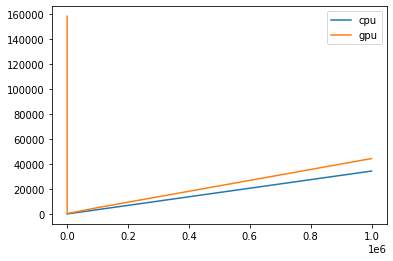

In [8]:
import matplotlib.pyplot as plt

cpu = [0, 1, 4, 34, 322, 3414, 34255];
gpu = [158024, 306, 267, 321, 764, 5020, 44249];
size = [1, 10, 100, 1000, 10000, 100000, 1000000];

fig, ax = plt.subplots()
ax.plot(size, cpu, label="cpu")
ax.plot(size, gpu, label="gpu")
ax.legend()

plt.show()